In [ ]:
!pip install torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install tensorflow-io
!pip install Ninja
!pip install dlib
!pip install cog

In [ ]:
!pip install gdown

In [ ]:
%cd /kaggle/working/
!git clone https://github.com/wty-ustc/HairCLIP.git

In [ ]:
%cd /kaggle/working/HairCLIP

In [ ]:
!git clone https://github.com/omertov/encoder4editing.git

# Data

In [ ]:
!gdown --id '1gof8kYc_gDLUT4wQlmUdAtPnQIlCO26q' -O "/kaggle/working/HairCLIP/mapper/datasets/train_faces.pt"

In [ ]:
!gdown --id '1j7RIfmrCoisxx3t-r-KC02Qc8barBecr' -O '/kaggle/working/HairCLIP/mapper/datasets/test_faces.pt'

In [ ]:
import torch
train_latents = torch.load("/kaggle/working/HairCLIP/mapper/datasets/train_faces.pt")

In [ ]:
test_latents = torch.load("/kaggle/working/HairCLIP/mapper/datasets/test_faces.pt")

In [ ]:
train_latents.shape, test_latents.shape

# Checkpoints

In [ ]:
!gdown --id '1cUv_reLE6k3604or78EranS7XzuVMWeO' -O "/kaggle/working/HairCLIP/pretrained_models/e4e_ffhq_encode.pt"

In [ ]:
!gdown --id '1pts5tkfAcWrg4TpLDu6ILF5wHID32Nzm' -O "/kaggle/working/HairCLIP/pretrained_models/stylegan2-ffhq-config-f.pt"

In [ ]:
!gdown --id '1hqZT6ZMldhX3M_x378Sm4Z2HMYr-UwQ4' -O "/kaggle/working/HairCLIP/pretrained_models/hairclip.pt"

In [ ]:
!gdown --id '1FS2V756j-4kWduGxfir55cMni5mZvBTv' -O "/kaggle/working/HairCLIP/pretrained_models/model_ir_se50.pth"

In [ ]:
!wget -P /kaggle/working/HairCLIP/pretrained_models http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /kaggle/working/HairCLIP/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

# LatentsDatasetInference.py

In [21]:
from torch.utils.data import Dataset
import sys
import numpy as np
import clip
import torch
import random
from PIL import Image
import torchvision.transforms as transforms
sys.path.insert(0, "/kaggle/working/HairCLIP/mapper")
from training import train_utils
import os

In [22]:
class LatentsDatasetInference(Dataset):
    def __init__(self, latents, opts):
        self.latents = latents
        self.opts = opts

        if self.opts.editing_type in ['hairstyle', 'both'] and self.opts.input_type.split('_')[0] == 'text':
            with open(self.opts.hairstyle_description, "r") as fd:
                self.hairstyle_description_list = fd.read().splitlines()
            self.hairstyle_list = [single_hairstyle_description[:-9] for single_hairstyle_description in self.hairstyle_description_list]
        if self.opts.editing_type in ['color', 'both'] and self.opts.input_type.split('_')[-1] == 'text':
            self.color_list = [single_color_description.strip()+' ' for single_color_description in self.opts.color_description.split(',')]
        if self.opts.editing_type in ['hairstyle', 'both'] and self.opts.input_type.split('_')[0] == 'image':
            self.out_domain_hairstyle_img_path_list = sorted(train_utils.make_dataset(self.opts.hairstyle_ref_img_test_path))
        if self.opts.editing_type in ['color', 'both'] and self.opts.input_type.split('_')[-1] == 'image':
            self.out_domain_color_img_path_list = sorted(train_utils.make_dataset(self.opts.color_ref_img_test_path))

        self.image_transform = transforms.Compose([transforms.Resize((1024, 1024)), transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


    def manipulate_hairstyle(self, index):
        if self.opts.input_type.split('_')[0] == 'text':
            color_text_embedding_list = [torch.Tensor([0]) for i in range(len(self.hairstyle_list))]
            color_tensor_list = [torch.Tensor([0]) for i in range(len(self.hairstyle_list))]
            hairstyle_tensor_list = [torch.Tensor([0]) for i in range(len(self.hairstyle_list))]
            selected_hairstyle_description_list = [single_hairstyle_description+'hairstyle' for single_hairstyle_description in self.hairstyle_list]
            hairstyle_text_embedding_list = [torch.cat([clip.tokenize(selected_hairstyle_description)])[0] for selected_hairstyle_description in selected_hairstyle_description_list]
        elif self.opts.input_type.split('_')[0] == 'image':
            color_text_embedding_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
            color_tensor_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
            hairstyle_text_embedding_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
            selected_hairstyle_description_list = ['hairstyle_out_domain_ref' for i in range(self.opts.num_of_ref_img)]
            hairstyle_tensor_list = [self.image_transform(Image.open(random.choice(self.out_domain_hairstyle_img_path_list))) for i in range(self.opts.num_of_ref_img)]
        return self.latents[index], hairstyle_text_embedding_list, color_text_embedding_list, selected_hairstyle_description_list, hairstyle_tensor_list, color_tensor_list


    def manipulater_color(self, index):
        if self.opts.input_type.split('_')[-1] == 'text':
            hairstyle_text_embedding_list = [torch.Tensor([0]) for i in range(len(self.color_list))]
            hairstyle_tensor_list = [torch.Tensor([0]) for i in range(len(self.color_list))]
            color_tensor_list = [torch.Tensor([0]) for i in range(len(self.color_list))]
            selected_color_description_list = [single_color_description+'hair' for single_color_description in self.color_list]
            color_text_embedding_list = [torch.cat([clip.tokenize(selected_color_description)])[0] for selected_color_description in selected_color_description_list]
        elif self.opts.input_type.split('_')[-1] == 'image':
            hairstyle_text_embedding_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
            hairstyle_tensor_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
            color_text_embedding_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
            selected_color_description_list = ['color_out_domain_ref' for i in range(self.opts.num_of_ref_img)]
            color_tensor_list = [self.image_transform(Image.open(random.choice(self.out_domain_color_img_path_list))) for i in range(self.opts.num_of_ref_img)]
        return self.latents[index], hairstyle_text_embedding_list, color_text_embedding_list, selected_color_description_list, hairstyle_tensor_list, color_tensor_list		


    def manipulater_hairstyle_and_color(self, index):
        returned_latent, hairstyle_text_embedding_list, _, selected_hairstyle_description_list, hairstyle_tensor_list, _ = self.manipulate_hairstyle(index)
        _, _, color_text_embedding_list, selected_color_description_list, _, color_tensor_list = self.manipulater_color(index)
        hairstyle_text_embedding_final_list = [hairstyle_text_embedding for hairstyle_text_embedding in hairstyle_text_embedding_list for i in color_text_embedding_list]
        color_text_embedding_final_list = [color_text_embedding for i in hairstyle_text_embedding_list for color_text_embedding in color_text_embedding_list]
        selected_description_list = [f'{selected_hairstyle_description}-{selected_color_description}' for selected_hairstyle_description in selected_hairstyle_description_list for selected_color_description in selected_color_description_list]
        hairstyle_tensor_final_list = [hairstyle_tensor for hairstyle_tensor in hairstyle_tensor_list for i in color_tensor_list]
        color_tensor_final_list = [color_tensor for i in hairstyle_tensor_list for color_tensor in color_tensor_list]
        return returned_latent, hairstyle_text_embedding_final_list, color_text_embedding_final_list, selected_description_list, hairstyle_tensor_final_list, color_tensor_final_list


    def __len__(self):
        return self.latents.shape[0]

    def __getitem__(self, index):
        if self.opts.editing_type == 'hairstyle':
            return self.manipulate_hairstyle(index)
        elif self.opts.editing_type == 'color':
            return self.manipulater_color(index)
        elif self.opts.editing_type == 'both':
            return self.manipulater_hairstyle_and_color(index)

# Predict.py

In [23]:
import sys
import tempfile
from argparse import Namespace

import dlib
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from cog import BasePredictor, Path, Input
from criteria.parse_related_loss import average_lab_color_loss

In [24]:
sys.path.insert(0, "encoder4editing")
from models.psp import pSp
from utils.alignment import align_face

In [25]:
sys.path.insert(0, "mapper")
# from mapper.datasets.latents_dataset_inference import LatentsDatasetInference
from mapper.hairclip_mapper import HairCLIPMapper
from mapper.options.test_options import TestOptions

In [26]:
%matplotlib inline
with open("mapper/hairstyle_list.txt") as infile:
    HAIRSTYLE_LIST = sorted([line.rstrip() for line in infile])


class Predictor_e4e(BasePredictor):
    def setup(self):
        self.device = "cuda:0"
        # use e4e to get latent code for an input image
        e4e_model_path = "pretrained_models/e4e_ffhq_encode.pt"
        e4e_ckpt = torch.load(e4e_model_path, map_location="cpu")
        e4e_opts = e4e_ckpt["opts"]
        e4e_opts["checkpoint_path"] = e4e_model_path
        e4e_opts = Namespace(**e4e_opts)

        self.e4e_net = pSp(e4e_opts)
        self.e4e_net.eval()
        self.e4e_net.cuda()
        print("e4e model successfully loaded!")
        
        self.img_transforms = transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )

        # HairClip model
        checkpoint_path = "pretrained_models/hairclip.pt"
        self.ckpt = torch.load(checkpoint_path, map_location="cpu")
        
    
    def predict(
        self,
        image: Path = Input(
            description="Input image. Image will be aligned and resized. Output will be the "
            "concatenation of the inverted input and the image with edited hair."
        ),
        editing_type: str = Input(
            choices=["hairstyle", "color", "both"],
            default="hairstyle",
            description="Edit hairstyle or color or both.",
        ),
        input_type: str = Input(
            choices = ["text", "image", "text_image", "image_text"],
            description="(1)_(2):  (1) for hairstyle and (2) for color"
        ),
        hairstyle_description: str = Input(
            choices=HAIRSTYLE_LIST,
            default=None,
            description="Hairstyle text prompt. "
            "Valid if input_type is text or text_image.",
        ),
        hairstyle_ref_img_test_path: Path = Input(),
        
        color_description: str = Input(
            default=None,
            description="Color text prompt, eg: purple, red, orange. "
            "Valid if editing_type is color or both.",
        ),
        color_ref_img_test_path: Path = Input()
    ) -> Path:
        
        editing_type_ = str(editing_type).split(".")[-1]
        hairstyle_description_ = str(hairstyle_description).split(".")[-1]
        

        if editing_type_ == "both":
            assert (
                hairstyle_description_ is not None and color_description is not None
            ), ("Please provide description " "for both hairstyle and color.")
        elif editing_type_ == "hairstyle":
            assert (
                hairstyle_description_ is not None
            ), "Please provide description for hairstyle."
        else:
            assert (
                color_description is not None
            ), "Please provide description for color."

        opts = self.ckpt["opts"]
        opts = Namespace(**opts)
        
        opts.num_of_ref_img = 5
        opts.editing_type = editing_type_
        opts.input_type = input_type
        opts.color_description = color_description
        if hairstyle_description is not None:
            with open("hairstyle_description.txt", "w") as file:
                file.write(hairstyle_description_)

            opts.hairstyle_description = "hairstyle_description.txt"
        opts.color_ref_img_test_path = color_ref_img_test_path
        opts.hairstyle_ref_img_test_path = hairstyle_ref_img_test_path
        
        opts.checkpoint_path = "pretrained_models/hairclip.pt"
        opts.parsenet_weights = "pretrained_models/parsenet.pth"
        opts.stylegan_weights = "pretrained_models/stylegan2-ffhq-config-f.pt"
        opts.ir_se50_weights = "pretrained_models/model_ir_se50.pth"
        net = HairCLIPMapper(opts)
        net.eval()
        net.cuda()

        # first align, resize image and get latent code
        input_image = run_alignment(str(image))
        resize_dims = (256, 256)
        input_image.resize(resize_dims)
        transformed_image = self.img_transforms(input_image)

        with torch.no_grad():

            images, latents = run_on_batch_e4e(
                transformed_image.unsqueeze(0), self.e4e_net
            )
            print("Latent code calculated!")
            print(f"Latent code shape: {latents.shape}")

        dataset = LatentsDatasetInference(latents=latents.cpu(), opts=opts)
        dataloader = DataLoader(dataset)

        average_color_loss = (
            average_lab_color_loss.AvgLabLoss(opts).to(self.device).eval()
        )

        out_path = Path("/kaggle/working/output.png")

        for input_batch in tqdm(dataloader):

            with torch.no_grad():

                (
                    w,
                    hairstyle_text_inputs_list,
                    color_text_inputs_list,
                    selected_description_tuple_list,
                    hairstyle_tensor_list,
                    color_tensor_list,
                ) = input_batch
                hairstyle_text_inputs = hairstyle_text_inputs_list[0]
                color_text_inputs = color_text_inputs_list[0]
                selected_description = selected_description_tuple_list[0][0]
                hairstyle_tensor = hairstyle_tensor_list[0]
                color_tensor = color_tensor_list[0]
                
                
                w = w.cuda().float()
                hairstyle_text_inputs = hairstyle_text_inputs.cuda()
                color_text_inputs = color_text_inputs.cuda()
                hairstyle_tensor = hairstyle_tensor.cuda()
                color_tensor = color_tensor.cuda()
                
                if hairstyle_tensor.shape[1] != 1:
                    hairstyle_tensor_hairmasked = (
                        hairstyle_tensor * average_color_loss.gen_hair_mask(hairstyle_tensor)
                    )
                else:
                    hairstyle_tensor_hairmasked = torch.Tensor([0]).unsqueeze(0).cuda()
                    
                if color_tensor.shape[1] != 1:
                    color_tensor_hairmasked = (
                        color_tensor * average_color_loss.gen_hair_mask(color_tensor)
                    )
                else:
                    color_tensor_hairmasked = torch.Tensor([0]).unsqueeze(0).cuda()
                    
                result_batch = run_on_batch(
                    w,
                    hairstyle_text_inputs,
                    color_text_inputs,
                    hairstyle_tensor_hairmasked,
                    color_tensor_hairmasked,
                    net,
                )

                if (hairstyle_tensor.shape[1] != 1) and (color_tensor.shape[1] != 1):
                    img_tensor = torch.cat([hairstyle_tensor, color_tensor], dim=3)
                elif hairstyle_tensor.shape[1] != 1:
                    img_tensor = hairstyle_tensor
                elif color_tensor.shape[1] != 1:
                    img_tensor = color_tensor
                else:
                    img_tensor = None

                if img_tensor is not None:
                    if img_tensor.shape[3] == 1024:
                        couple_output = torch.cat(
                            [
                                result_batch[2][0].unsqueeze(0),
                                img_tensor,
                                result_batch[0][0].unsqueeze(0),
                            ]
                        )
                    elif img_tensor.shape[3] == 2048:
                        couple_output = torch.cat(
                            [
                                result_batch[2][0].unsqueeze(0),
                                result_batch[0][0].unsqueeze(0),
                                img_tensor[:, :, :, 0:1024],
                                img_tensor[:, :, :, 1024::],
                            ]
                        )
                        couple_output = torch.cat(
                            [
                                result_batch[2][0].unsqueeze(0),
                                result_batch[0][0].unsqueeze(0),
                                img_tensor[:, :, :, 0:1024],
                                img_tensor[:, :, :, 1024::],
                            ]
                        )
                else:
                    couple_output = torch.cat(
                        [
                            result_batch[2][0].unsqueeze(0),
                            result_batch[0][0].unsqueeze(0),
                        ]
                    )
                    
                torchvision.utils.save_image(
                    couple_output, str(out_path), normalize=True
                )

                
        return out_path

In [27]:
datFile = "/kaggle/working/HairCLIP/pretrained_models/shape_predictor_68_face_landmarks.dat"
def run_alignment(image_path):
    predictor = dlib.shape_predictor(datFile)
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image

In [28]:
def run_on_batch_e4e(inputs, net):
    images, latents = net(
        inputs.to("cuda").float(), randomize_noise=False, return_latents=True
    )
    return images, latents

In [29]:
def run_on_batch(
    inputs,
    hairstyle_text_inputs,
    color_text_inputs,
    hairstyle_tensor_hairmasked,
    color_tensor_hairmasked,
    net,
):
    w = inputs
    with torch.no_grad():
        w_hat = w + 0.1 * net.mapper(
            w,
            hairstyle_text_inputs,
            color_text_inputs,
            hairstyle_tensor_hairmasked,
            color_tensor_hairmasked,
        )
        x_hat, w_hat = net.decoder(
            [w_hat],
            input_is_latent=True,
            return_latents=True,
            randomize_noise=False,
            truncation=1,
        )
        x, _ = net.decoder(
            [w], input_is_latent=True, randomize_noise=False, truncation=1
        )
        result_batch = (x_hat, w_hat, x)
    return result_batch

# Check image

## Input_image

In [4]:
import shutil
import os

# Define a function to remove a directory and its contents recursively
def remove_folder(folder_path):
    shutil.rmtree(folder_path)

# Example usage:
if os.path.exists('/kaggle/working/Image'):
    remove_folder('/kaggle/working/Image')
    
!git clone https://github.com/HongQuan2003/21522490_final_ACV.git /kaggle/working/Image

Cloning into '/kaggle/working/Image'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), 12.90 MiB | 14.49 MiB/s, done.


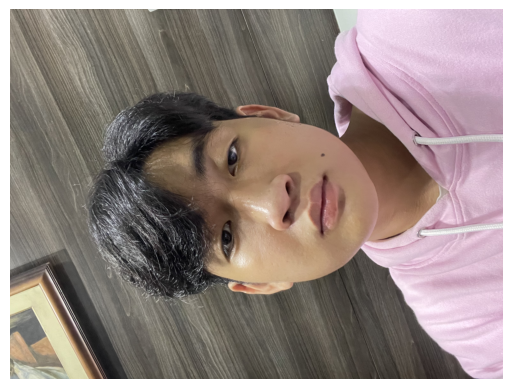

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.io as io

input_image_path = "/kaggle/working/Image/Input_image/IMG_0127.jpeg"
input_image = io.read_image(input_image_path)

# Plot the image
plt.imshow(input_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Rotate (if needed)**

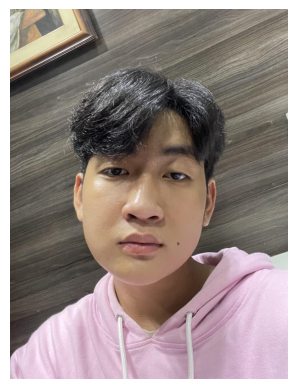

In [6]:
rotated_input_image_path = "/kaggle/working/rotated_input_image.jpeg"

# Rotate the image tensor by 90 degrees counter-clockwise
rotated_input_image = torch.rot90(input_image, k=-1, dims=(1, 2))

# Convert the rotated tensor back to a PIL Image
rotated_input_image = TF.to_pil_image(rotated_input_image)

# Save the rotated image
rotated_input_image.save(rotated_input_image_path)

# Assuming 'image_tensor' is your image tensor
input_image = io.read_image(rotated_input_image_path)

# Plot the image
plt.imshow(input_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

input_image_path = rotated_input_image_path

## Ref_image

### hairstyle

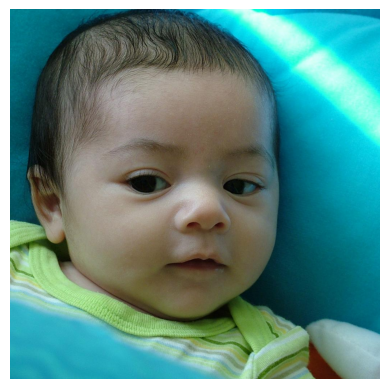

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.io as io
import os

ref_image_path = "/kaggle/input/flickr-faces-hq-dataset-ffhq/images1024x1024/00000.png"

if os.path.exists('/kaggle/working/reference_image_hairstyle') == False:
    os.mkdir('/kaggle/working/reference_image_hairstyle')
    
ref_image = io.read_image(ref_image_path)
ref_image = TF.to_pil_image(ref_image)
ref_image.save("/kaggle/working/reference_image_hairstyle/ref_img.jpeg")


ref_image = io.read_image("/kaggle/working/reference_image_hairstyle/ref_img.jpeg")
# Plot the image
plt.imshow(ref_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Rotate (if needed)**

In [ ]:
# Rotate the image tensor by 90 degrees counter-clockwise
rotated_ref_image = torch.rot90(ref_image, k=-1, dims=(1, 2))

# Convert the rotated tensor back to a PIL Image
rotated_ref_image = TF.to_pil_image(rotated_ref_image)

# Save the rotated image
rotated_ref_image.save("/kaggle/working/reference_image_hairstyle/ref_img.jpeg")

# Assuming 'image_tensor' is your image tensor
ref_image = io.read_image("/kaggle/working/reference_image_hairstyle/ref_img.jpeg")

# Plot the image
plt.imshow(ref_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Color

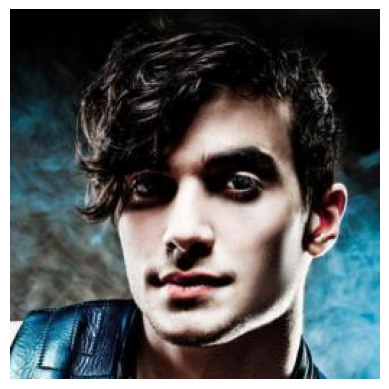

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.io as io
import os

ref_image_path = "/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00003.jpg"

if os.path.exists('/kaggle/working/reference_image_color') == False:
    os.mkdir('/kaggle/working/reference_image_color')
    
ref_image = io.read_image(ref_image_path)
ref_image = TF.to_pil_image(ref_image)
ref_image.save("/kaggle/working/reference_image_color/ref_img.jpeg")


ref_image = io.read_image("/kaggle/working/reference_image_color/ref_img.jpeg")
# Plot the image
plt.imshow(ref_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Rotate (if needed)**


In [ ]:
# Rotate the image tensor by 90 degrees counter-clockwise
rotated_ref_image = torch.rot90(ref_image, k=-1, dims=(1, 2))

# Convert the rotated tensor back to a PIL Image
rotated_ref_image = TF.to_pil_image(rotated_ref_image)

# Save the rotated image
rotated_ref_image.save("/kaggle/working/reference_image_color/ref_img.jpeg")

# Assuming 'image_tensor' is your image tensor
ref_image = io.read_image("/kaggle/working/reference_image_color/ref_img.jpeg")

# Plot the image
plt.imshow(ref_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

# Edit hair with HairClip_e4e

In [9]:
%cd /kaggle/working/HairCLIP

/kaggle/working/HairCLIP


In [19]:
Hair_clip_e4e = Predictor_e4e()
Hair_clip_e4e.setup()

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
e4e model successfully loaded!


In [30]:
%matplotlib inline

outpath = Hair_clip_e4e.predict(
        image = input_image_path,
        editing_type = "both",
        input_type = "image_text",
        hairstyle_description = "dreadlocks hairstyle",
        color_description = "purple",
        hairstyle_ref_img_test_path = "/kaggle/working/reference_image_hairstyle",
        color_ref_img_test_path = "/kaggle/working/reference_image_color",
)

Loading from checkpoint: pretrained_models/hairclip.pt
Aligned image has shape: (256, 256)
Latent code calculated!
Latent code shape: torch.Size([1, 18, 512])
Loading UNet for AvgLabLoss


100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


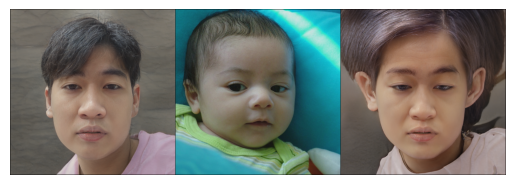

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.io as io

# Assuming 'image_tensor' is your image tensor
output_image = io.read_image(str(outpath))

# Plot the image
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')
plt.show()